## ProjF5 - Final Model

Use this document as a template to provide the evaluation of your final model. You are welcome to go in as much depth as needed.

Make sure you keep the sections specified in this template, but you are welcome to add more cells with your code or explanation as needed.

In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

import pandas as pd
from sklearn import preprocessing
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.pipeline import Pipeline
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics
from sklearn.metrics import confusion_matrix, recall_score, precision_score

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense, Dropout
np.random.seed(42)

### 1. Load and Prepare Data

This should illustrate your code for loading the dataset and the split into training, validation and testing. You can add steps like pre-processing if needed.

In [ ]:
#Reading all data and setting all the column names are expected

index_names = ['id', 'cycle']
setting_names = ['setting1', 'setting2', 'setting3']
sensor_names=[f's{i}' for i in range(1,24)]
col_names = index_names + setting_names + sensor_names
rul_names = ['RUL']

train_data = pd.read_csv("/content/drive/Shared drives/NNDL_Proj/PM_train.txt", header=None, sep=" ",names=col_names)
test_data = pd.read_csv("/content/drive/Shared drives/NNDL_Proj/PM_test.txt", header=None, sep=" ",names=col_names)
truth_data = pd.read_csv("/content/drive/Shared drives/NNDL_Proj/PM_truth.txt", header=None, sep=" ",names=col_names)

train_data.dropna(axis=1, inplace=True)
test_data.dropna(axis=1, inplace=True)
truth_data.dropna(axis=1, inplace=True)

np.random.seed(42)
w1 = 30

In [ ]:
# Used to set the RUL value on train and test dataset, RUL = none is for train and not null if for Test set
# Function looks at the breaking cycle and current cycle to determine the RUL value

def prepare_data(df, rul = None):
  df.sort_values(['id', 'cycle'], inplace = True)

  if rul is None:
    rul = pd.DataFrame(train_data.groupby('id')['cycle'].max()).reset_index()
    rul.columns = ['id' , 'max']

  df = df.merge(rul, on=['id'], how='left')
  df['RUL'] = df['max'] - df['cycle']
  df.drop('max', axis = 1, inplace = True)

  df['failure_within_w1'] = np.where(df['RUL'] <= w1, 1, 0)

  return df

In [ ]:
# Prepare RUL values for Training dataset
train_df = prepare_data(train_data)

In [ ]:
# Data preperation since Truth dataset contains the RUL value for the last cycle and hence we need to use that to determine all cycles RUL values

truth_temp_df = pd.DataFrame(test_data.groupby('id')['cycle'].max()).reset_index()
truth_temp_df.columns = ['id', 'true_rul']
truth_temp_df['max'] = truth_temp_df['true_rul'][:] + truth_data['id'][:]
truth_temp_df.drop(['true_rul'], axis=1, inplace=True)


In [ ]:
# Prepare RUL values for Test dataset
test_df = prepare_data(test_data, rul=truth_temp_df)

In [ ]:
# For normalizing required columns
def normalize_data(df_train, df_test):

  cols_normalize = df_train.columns.difference(['id','cycle','RUL'])

  min_max_scaler = preprocessing.MinMaxScaler()
  norm_df_train = pd.DataFrame(min_max_scaler.fit_transform(df_train[cols_normalize]),
                              columns=cols_normalize,
                              index=df_train.index)

  join_df = df_train[['id','cycle','RUL']].join(norm_df_train)
  df_train = join_df.reindex(columns = df_train.columns)

  norm_df_test = pd.DataFrame(min_max_scaler.transform(df_test[cols_normalize]),
                            columns=cols_normalize,
                            index=df_test.index)

  test_join_df = df_test[df_test.columns.difference(cols_normalize)].join(norm_df_test)
  df_test = test_join_df.reindex(columns = df_test.columns)
  df_test = df_test.reset_index(drop=True)


  return df_train, df_test

In [ ]:
train_df, test_df = normalize_data(train_df, test_df)

In [ ]:
train_df.describe()

,id,cycle,setting1,setting2,setting3,s1,s2,s3,s4,s5,...,s14,s15,s16,s17,s18,s19,s20,s21,RUL,failure_within_w1
count,20631.000000,20631.000000,20631.000000,20631.000000,20631.0,20631.0,20631.000000,20631.000000,20631.000000,20631.0,...,20631.000000,20631.000000,20631.0,20631.000000,20631.0,20631.0,20631.000000,20631.000000,20631.000000,20631.000000
mean,51.506568,108.807862,0.499490,0.501959,0.0,0.0,0.443052,0.424746,0.450435,0.0,...,0.226095,0.451118,0.0,0.434221,0.0,0.0,0.524241,0.546127,107.807862,0.150259
std,29.227633,68.880990,0.125708,0.244218,0.0,0.0,0.150618,0.133664,0.151935,0.0,...,0.098442,0.144306,0.0,0.129064,0.0,0.0,0.140114,0.149476,68.880990,0.357334
min,1.000000,1.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,...,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000
25%,26.000000,52.000000,0.413793,0.333333,0.0,0.0,0.335843,0.331807,0.339467,0.0,...,0.171870,0.346287,0.0,0.333333,0.0,0.0,0.434109,0.452361,51.000000,0.000000
50%,52.000000,104.000000,0.500000,0.500000,0.0,0.0,0.430723,0.415522,0.435348,0.0,...,0.209516,0.438630,0.0,0.416667,0.0,0.0,0.534884,0.557443,103.000000,0.000000
75%,77.000000,156.000000,0.586207,0.750000,0.0,0.0,0.539157,0.508829,0.545324,0.0,...,0.249613,0.541362,0.0,0.500000,0.0,0.0,0.627907,0.652582,155.000000,0.000000
max,100.000000,362.000000,1.000000,1.000000,0.0,0.0,1.000000,1.000000,1.000000,0.0,...,1.000000,1.000000,0.0,1.000000,0.0,0.0,1.000000,1.000000,361.000000,1.000000


In [ ]:
# The sequence length is choosen as follows
sequence_length = 30

In [ ]:
# The function to generate sequences (samples, time steps, features) for a particular engine id is as follows:

def sequence_generator(feature_df, seq_length, seq_cols):

    feature_array = feature_df[seq_cols].values
    num_elements = feature_array.shape[0]


    for start, stop in zip(range(0, num_elements-seq_length), range(seq_length, num_elements)):
        yield feature_array[start:stop, :]

In [ ]:
# droping sensors 1, 5, 6, 10, 14, 16, 18, and 19
settings_labels = ['setting1', 'setting2', 'setting3', ]
sensor_lables = ['s2', 's3', 's4', 's7', 's8', 's9', 's11', 's12', 's13', 's15', 's17', 's20', 's21']

In [ ]:
def label_generator(label_df, seq_length, label):
    # Funtion will return

    label_array = label_df[label].values
    num_elements = label_array.shape[0]
    return label_array[seq_length:num_elements, :]

In [ ]:
# Building Sequences for TRAIN Set

seq_gen = (list(sequence_generator(train_df[train_df['id']==id], sequence_length, settings_labels + sensor_lables))
           for id in train_df['id'].unique())

seq_set = np.concatenate(list(seq_gen)).astype(np.float32)
seq_set.shape


(17631, 30, 16)

In [ ]:
# Building Sequences for Test Set

seq_gen_test = (list(sequence_generator(test_df[test_df['id']==id], sequence_length, settings_labels + sensor_lables))
           for id in test_df['id'].unique())

seq_set_test = np.concatenate(list(seq_gen_test)).astype(np.float32)
seq_set_test.shape

(10096, 30, 16)

In [ ]:
# Training labels

label_gen = [label_generator(train_df[train_df['id']==id], sequence_length, ['failure_within_w1'])
             for id in train_df['id'].unique()]
label_set = np.concatenate(label_gen).astype(np.float32)
label_set.shape

(17631, 1)

In [ ]:
# Test labels

label_gen_test = [label_generator(test_df[test_df['id']==id], sequence_length, ['failure_within_w1'])
             for id in test_df['id'].unique()]
label_set_test = np.concatenate(label_gen_test).astype(np.float32)
label_set_test.shape

(10096, 1)

### 2. Prepare your Final Model

Here you can have your code to either train (e.g., if you are building it from scratch) your model. These steps may require you to use other packages or python files. You can just call them here. You don't have to include them in your submission. Remember that we will be looking at the saved outputs in the notebooked and we will not run the entire notebook.

#### RNN

In [ ]:
features_dim = seq_set.shape[2] # number of features (16).
out_dim = label_set.shape[1] # One label (failure_within_w1).

print("Features dimension: ", features_dim)
print("Output dimension: ", out_dim)

RNN_fwd_2 = Sequential()

RNN_fwd_2.add(SimpleRNN(
         input_shape=(sequence_length, features_dim),
         units=5,
         return_sequences=True))
RNN_fwd_2.add(Dropout(0.2))

RNN_fwd_2.add(SimpleRNN(
          units=3,
          return_sequences=False))
RNN_fwd_2.add(Dropout(0.2))

RNN_fwd_2.add(Dense(units=out_dim, activation='sigmoid'))

# Compile the model.
RNN_fwd_2.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

RNN_fwd_2.summary()

Features dimension:  16
Output dimension:  1
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn (SimpleRNN)      (None, 30, 5)             110       
                                                                 
 dropout (Dropout)           (None, 30, 5)             0         
                                                                 
 simple_rnn_1 (SimpleRNN)    (None, 3)                 27        
                                                                 
 dropout_1 (Dropout)         (None, 3)                 0         
                                                                 
 dense (Dense)               (None, 1)                 4         
                                                                 
Total params: 141 (564.00 Byte)
Trainable params: 141 (564.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_______________________________________

In [ ]:
from tensorflow import keras
from sklearn.utils.class_weight import compute_class_weight

# Convert class weights to a dictionary
epochs = 60
batch_size = 200

# Fit the network.
RNN_fwd_2_history = RNN_fwd_2.fit(seq_set, label_set, epochs=epochs, batch_size=batch_size, verbose=2, validation_split=0.05
                                  )

Epoch 1/60
84/84 - 4s - loss: 0.6274 - accuracy: 0.7667 - val_loss: 0.5629 - val_accuracy: 0.8243 - 4s/epoch - 43ms/step
Epoch 2/60
84/84 - 1s - loss: 0.5364 - accuracy: 0.8229 - val_loss: 0.4935 - val_accuracy: 0.8243 - 1s/epoch - 12ms/step
Epoch 3/60
84/84 - 1s - loss: 0.4933 - accuracy: 0.8242 - val_loss: 0.4724 - val_accuracy: 0.8243 - 1s/epoch - 12ms/step
Epoch 4/60
84/84 - 2s - loss: 0.4818 - accuracy: 0.8241 - val_loss: 0.4663 - val_accuracy: 0.8243 - 2s/epoch - 27ms/step
Epoch 5/60
84/84 - 3s - loss: 0.4772 - accuracy: 0.8242 - val_loss: 0.4620 - val_accuracy: 0.8243 - 3s/epoch - 34ms/step
Epoch 6/60
84/84 - 2s - loss: 0.4584 - accuracy: 0.8246 - val_loss: 0.4275 - val_accuracy: 0.8243 - 2s/epoch - 24ms/step
Epoch 7/60
84/84 - 1s - loss: 0.4068 - accuracy: 0.8340 - val_loss: 0.3305 - val_accuracy: 0.8503 - 1s/epoch - 12ms/step
Epoch 8/60
84/84 - 1s - loss: 0.2981 - accuracy: 0.9031 - val_loss: 0.2284 - val_accuracy: 0.9354 - 1s/epoch - 12ms/step
Epoch 9/60
84/84 - 1s - loss: 0.

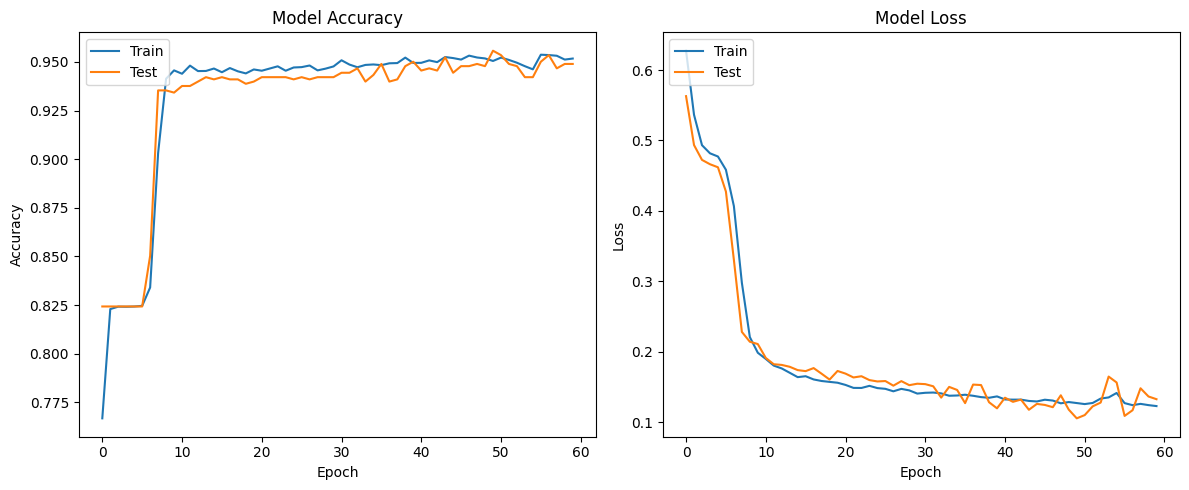

In [ ]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2, figsize=(12, 5))  # 1 row, 2 columns

# Plot accuracy
axes[0].plot(RNN_fwd_2_history.history['accuracy'])
axes[0].plot(RNN_fwd_2_history.history['val_accuracy'])
axes[0].set_title('Model Accuracy')
axes[0].set_ylabel('Accuracy')
axes[0].set_xlabel('Epoch')
axes[0].legend(['Train', 'Test'], loc='upper left')

# Plot loss
axes[1].plot(RNN_fwd_2_history.history['loss'])
axes[1].plot(RNN_fwd_2_history.history['val_loss'])
axes[1].set_title('Model Loss')
axes[1].set_ylabel('Loss')
axes[1].set_xlabel('Epoch')
axes[1].legend(['Train', 'Test'], loc='upper left')

plt.tight_layout()  # Adjust layout to prevent overlap
plt.show()


#### LSTM

In [ ]:
from tensorflow.keras.layers import LSTM

features_dim = seq_set.shape[2] # number of features
out_dim = label_set.shape[1] # 1 Label (Target variable is failure_within_w1)

print("Features dimension: ", features_dim)
print("Output dimension: ", out_dim)

LSTM_model = Sequential()

LSTM_model.add(LSTM(
         input_shape=(sequence_length, features_dim),
         units=100,
         return_sequences=True))
LSTM_model.add(Dropout(0.2))

LSTM_model.add(LSTM(
          units=50,
          return_sequences=False))
LSTM_model.add(Dropout(0.2))

LSTM_model.add(Dense(units=out_dim, activation='sigmoid'))

# Compile the model
LSTM_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

print(LSTM_model.summary())

Features dimension:  16
Output dimension:  1
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 30, 100)           46800     
                                                                 
 dropout_4 (Dropout)         (None, 30, 100)           0         
                                                                 
 lstm_3 (LSTM)               (None, 50)                30200     
                                                                 
 dropout_5 (Dropout)         (None, 50)                0         
                                                                 
 dense_2 (Dense)             (None, 1)                 51        
                                                                 
Total params: 77051 (300.98 KB)
Trainable params: 77051 (300.98 KB)
Non-trainable params: 0 (0.00 Byte)
_____________________________________

In [ ]:
import time
epochs = 60
batch_size = 200
start = time.time()
model_path = './'

history = LSTM_model.fit(seq_set, label_set, epochs=epochs, batch_size=batch_size, validation_split=0.05, verbose=2,
          callbacks = [
              keras.callbacks.ModelCheckpoint(model_path, monitor='val_loss', save_best_only=True, mode='min', verbose=0)
          ]
          )
end = time.time()
print("Total time taken for training: ", "{:.2f}".format((end-start)), " secs")

Epoch 1/60
84/84 - 24s - loss: 0.2466 - accuracy: 0.9005 - val_loss: 0.1254 - val_accuracy: 0.9490 - 24s/epoch - 287ms/step
Epoch 2/60
84/84 - 26s - loss: 0.1050 - accuracy: 0.9579 - val_loss: 0.0800 - val_accuracy: 0.9615 - 26s/epoch - 304ms/step
Epoch 3/60
84/84 - 15s - loss: 0.0887 - accuracy: 0.9620 - val_loss: 0.1005 - val_accuracy: 0.9501 - 15s/epoch - 179ms/step
Epoch 4/60
84/84 - 33s - loss: 0.0818 - accuracy: 0.9667 - val_loss: 0.0765 - val_accuracy: 0.9649 - 33s/epoch - 397ms/step
Epoch 5/60
84/84 - 22s - loss: 0.0796 - accuracy: 0.9662 - val_loss: 0.1106 - val_accuracy: 0.9490 - 22s/epoch - 260ms/step
Epoch 6/60
84/84 - 29s - loss: 0.0824 - accuracy: 0.9647 - val_loss: 0.0652 - val_accuracy: 0.9660 - 29s/epoch - 343ms/step
Epoch 7/60
84/84 - 12s - loss: 0.0754 - accuracy: 0.9678 - val_loss: 0.0685 - val_accuracy: 0.9671 - 12s/epoch - 143ms/step
Epoch 8/60
84/84 - 23s - loss: 0.0780 - accuracy: 0.9669 - val_loss: 0.0521 - val_accuracy: 0.9807 - 23s/epoch - 276ms/step
Epoch 9/

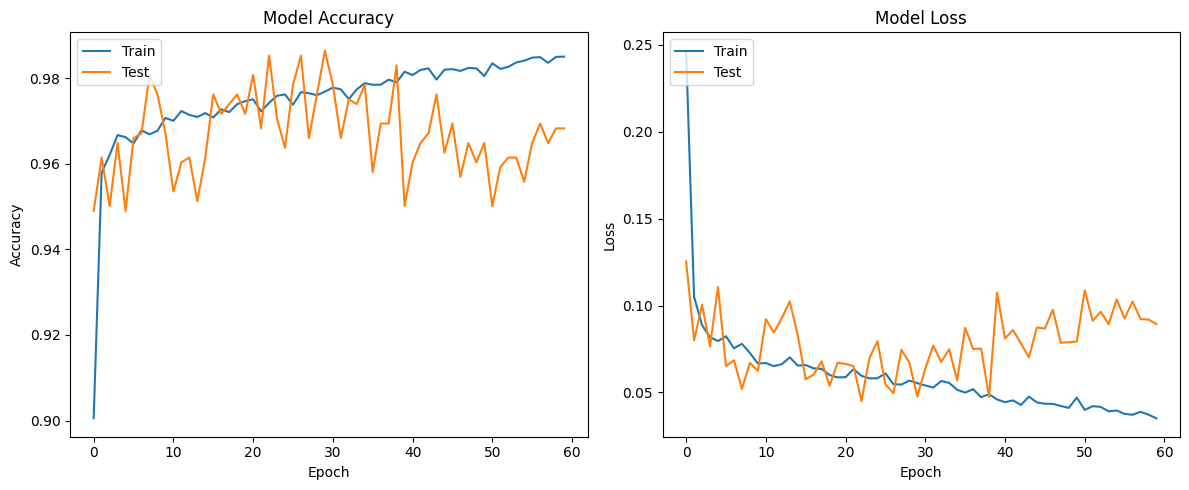

In [ ]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Plot accuracy
axes[0].plot(history.history['accuracy'])
axes[0].plot(history.history['val_accuracy'])
axes[0].set_title('Model Accuracy')
axes[0].set_ylabel('Accuracy')
axes[0].set_xlabel('Epoch')
axes[0].legend(['Train', 'Test'], loc='upper left')

# Plot loss
axes[1].plot(history.history['loss'])
axes[1].plot(history.history['val_loss'])
axes[1].set_title('Model Loss')
axes[1].set_ylabel('Loss')
axes[1].set_xlabel('Epoch')
axes[1].legend(['Train', 'Test'], loc='upper left')

plt.tight_layout()
plt.show()


### 3. Model Performance

Make sure to include the following:
- Performance on the training set
- Performance on the test set
- Provide some screenshots of your output (e.g., pictures, text output, or a histogram of predicted values in the case of tabular data). Any visualization of the predictions are welcome.

In [ ]:
# Considering all the last sequences of test set
last_test_seq = [test_df[test_df['id']==id][settings_labels + sensor_lables].values[-sequence_length:]
                       for id in test_df['id'].unique() if len(test_df[test_df['id']==id]) >= sequence_length]
last_test_seq = np.asarray(last_test_seq).astype(np.float32)

# Get labels of test set
y_mask = [len(test_df[test_df['id']==id]) >= sequence_length for id in test_df['id'].unique()]
last_test_label = test_df.groupby('id')['failure_within_w1'].nth(-1)[y_mask].values
last_test_label = last_test_label.reshape(last_test_label.shape[0],1).astype(np.float32)

#### RNN Performance

In [ ]:
import time
start = time.time()
scores_test = RNN_fwd_2.evaluate(last_test_seq, last_test_label, verbose=2)
end = time.time()
print("Total time taken for inferencing: ", "{:.2f}".format((end-start)), " secs")

print('Test Accurracy: {}'.format(scores_test[1]))

# Make predictions and compute the confusion matrix.
y_pred_test_rnn = (RNN_fwd_2.predict(last_test_seq) >0.5).astype("int32")
y_true_test = last_test_label

test_set = pd.DataFrame(y_pred_test_rnn)
test_set.to_csv('binary_submit_test.csv', index = None)

conf_m_rnn = confusion_matrix(y_true_test, y_pred_test_rnn)

print('Confusion matrix\n- x-axis is true labels.\n- y-axis is predicted labels')
conf_m_rnn = confusion_matrix(y_true_test, y_pred_test_rnn)
print(conf_m_rnn)

4/4 - 0s - loss: 0.1692 - accuracy: 0.9200 - 41ms/epoch - 10ms/step
Total time taken for inferencing:  0.16  secs
Test Accurracy: 0.9200000166893005
4/4 [==============================] - 0s 5ms/step
Confusion matrix
- x-axis is true labels.
- y-axis is predicted labels
[[74  1]
 [ 7 18]]


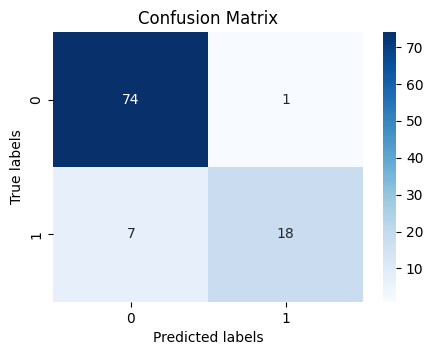

In [ ]:
# Plotting the confusion matrix
plt.figure(figsize=(5,3.5))
sns.heatmap(conf_m_rnn, annot=True, fmt='g', cmap='Blues')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

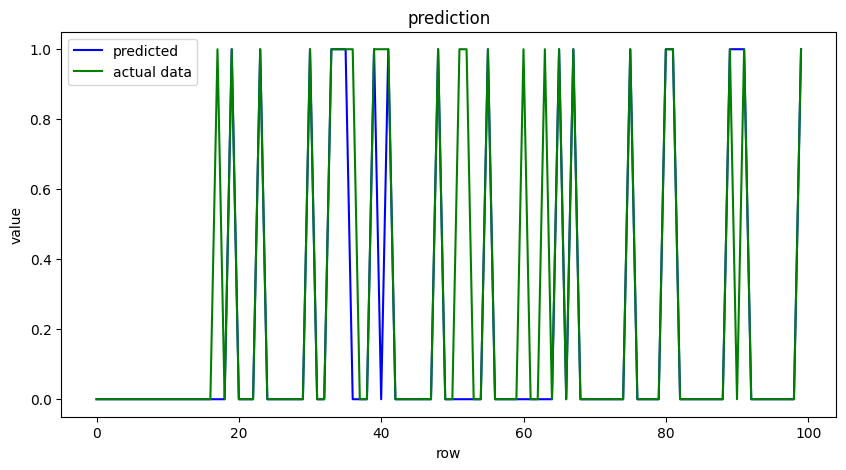

In [ ]:
# Plot in blue color the predicted data and in green color the
# Actual data to verify visually the accuracy of the model.
fig_verify = plt.figure(figsize=(10, 5))
plt.plot(y_pred_test_rnn, color="blue")
plt.plot(y_true_test, color="green")
plt.title('prediction')
plt.ylabel('value')
plt.xlabel('row')
plt.legend(['predicted', 'actual data'], loc='upper left')
plt.show()

#### LSTM Performance

In [ ]:
# Test metrics
start = time.time()
scores_test_lstm = LSTM_model.evaluate(last_test_seq, last_test_label, verbose=2)
end = time.time()
print("Total time taken for inferencing: ", "{:.2f}".format((end-start)), " secs")

print('Test Accurracy: {}'.format(scores_test_lstm[1]))

# Make predictions and compute confusion matrix
y_pred_test_lstm = (LSTM_model.predict(last_test_seq) > 0.5).astype("int32")
y_true_test_lstm = last_test_label

test_set = pd.DataFrame(y_pred_test_lstm)
test_set.to_csv('binary_submit_test.csv', index = None)

print('Confusion matrix\n- x-axis is true labels.\n- y-axis is predicted labels')
conf_m_lstm = confusion_matrix(y_true_test_lstm, y_pred_test_lstm)
print(conf_m_lstm)

# Compute precision and recall
precision_test = precision_score(y_true_test_lstm, y_pred_test_lstm)
recall_test = recall_score(y_true_test_lstm, y_pred_test_lstm)
f1_test = 2 * (precision_test * recall_test) / (precision_test + recall_test)
print( 'Test Precision: ', precision_test, '\n', 'Test Recall: ', recall_test,'\n', 'Test F1-score:', f1_test )



4/4 - 0s - loss: 0.0652 - accuracy: 0.9600 - 83ms/epoch - 21ms/step
Total time taken for inferencing:  0.19  secs
Test Accurracy: 0.9599999785423279
4/4 [==============================] - 0s 13ms/step
Confusion matrix
- x-axis is true labels.
- y-axis is predicted labels
[[74  1]
 [ 3 22]]
Test Precision:  0.9565217391304348 
 Test Recall:  0.88 
 Test F1-score: 0.9166666666666666


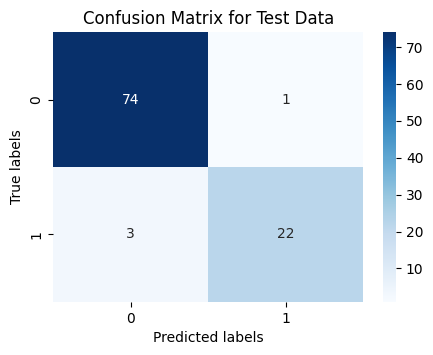

In [ ]:
# Plotting the confusion matrix for test data
plt.figure(figsize=(5,3.5))
sns.heatmap(conf_m_lstm, annot=True, fmt='g', cmap='Blues')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix for Test Data')
plt.show()

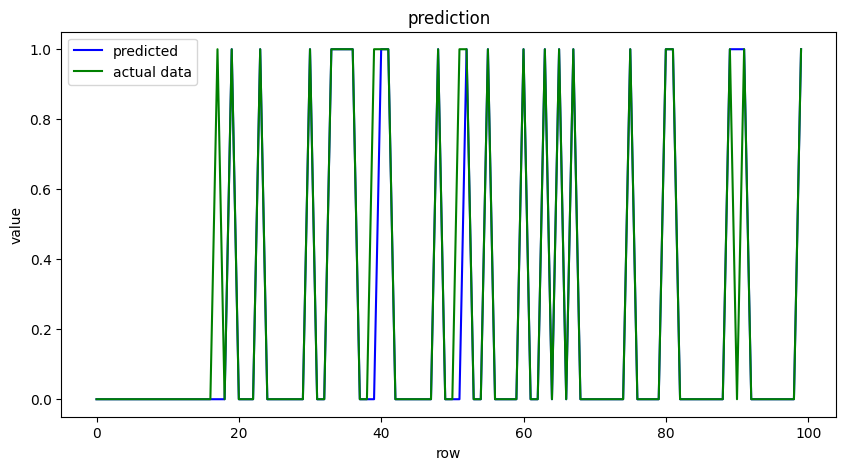

In [ ]:
# Plot in blue color the predicted data and in green color the
# Actual data to verify visually the accuracy of the model.
fig_verify = plt.figure(figsize=(10, 5))
plt.plot(y_pred_test_lstm, color="blue")
plt.plot(y_true_test, color="green")
plt.title('prediction')
plt.ylabel('value')
plt.xlabel('row')
plt.legend(['predicted', 'actual data'], loc='upper left')
plt.show()